In [1]:
path="/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images"

In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import VGG16,ResNet50,MobileNet, DenseNet201, InceptionV3,VGG19, NASNetLarge, InceptionResNetV2, NASNetMobile ,EfficientNetB0
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
# Changed import: ImageDataGenerator is now in tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

%matplotlib inline

2025-06-19 20:06:06.465738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750363566.709932      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750363566.775561      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#check the class of images

In [3]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Example paths (change as needed)

train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")
csv_path = os.path.join(path, "train_labels.csv")
# Load CSV
df = pd.read_csv(csv_path)

# Preview the data
print(df.head())


       filename   label
0  39d30b68.jpg  Naeimi
1  4a9853bd.jpg    Goat
2  d88facaa.jpg   Roman
3  a3f4f4af.jpg   Roman
4  16b31730.jpg  Naeimi


# visualize the distribution

Distribution of labels:
label
Naeimi     255
Goat       107
Sawakni     80
Roman       72
Najdi       71
Harri       62
Barbari     35
Name: count, dtype: int64


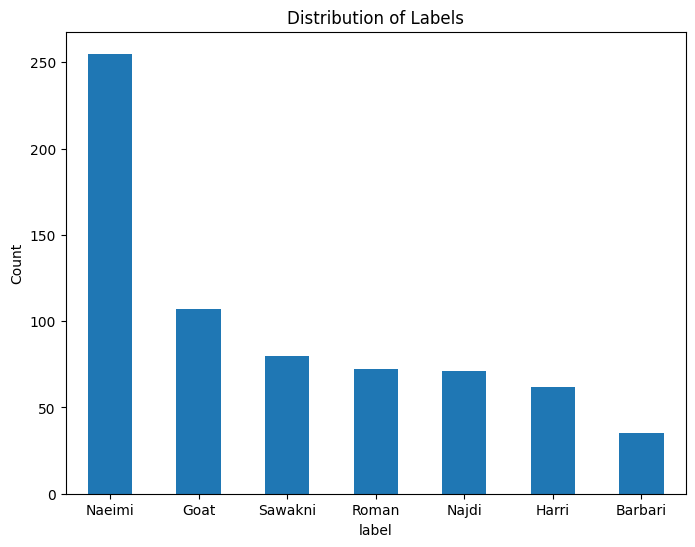

In [4]:


import matplotlib.pyplot as plt

label_column_name = 'label'

if label_column_name in df.columns:
    label_distribution = df[label_column_name].value_counts()
    print("Distribution of labels:")
    print(label_distribution)

    # You can also
    plt.figure(figsize=(8, 6))
    label_distribution.plot(kind='bar')
    plt.title('Distribution of Labels')
    plt.xlabel(label_column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()
else:
    print(f"Column '{label_column_name}' not found in the DataFrame.")



#chek the null or nan

In [5]:

print("Checking for null or NaN values:")
print(df.isnull().sum())

Checking for null or NaN values:
filename    0
label       0
dtype: int64


#display random image  train - test

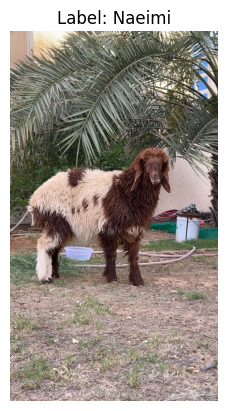

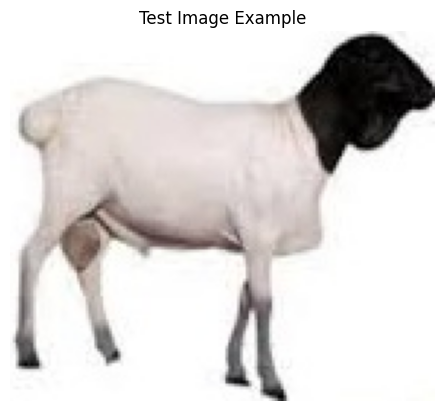

In [6]:
# Read one train image
first_train_img = df['filename'].iloc[0]
img_path = os.path.join(train_dir, first_train_img)

# Open and display the image
img = Image.open(img_path)
plt.imshow(img)
plt.title(f"Label: {df['label'].iloc[0]}")
plt.axis('off')
plt.show()

# Optionally read a test image
test_images = sorted(os.listdir(test_dir))
test_img_path = os.path.join(test_dir, test_images[0])
img_test = Image.open(test_img_path)
plt.imshow(img_test)
plt.title("Test Image Example")
plt.axis('off')
plt.show()



#print 10 example of train image

In [7]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(10):
    image_name = df['filename'].iloc[i]
    image_path = os.path.join(train_dir, image_name)
    img = Image.open(image_path)
    label = df['label'].iloc[i]
    plt.subplot(5, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


#split data into val and train

In [8]:

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

# Display the first few rows of the training and validation sets
print("\nTraining set head:")
print(train_df.head())

print("\nValidation set head:")
print(val_df.head())

# Check the distribution of labels in the split sets
print("\nLabel distribution in Training set:")
print(train_df['label'].value_counts().sort_index())

print("\nLabel distribution in Validation set:")
print(val_df['label'].value_counts().sort_index())

Training set size: 545
Validation set size: 137

Training set head:
         filename   label
522  18755cc0.jpg    Goat
43   5e433d3c.jpg  Naeimi
472  b0ae67c3.jpg    Goat
328  f57bdd88.jpg  Naeimi
293  bdb8f65c.jpg  Naeimi

Validation set head:
         filename   label
678  fc48f9e0.jpg    Goat
406  ffe86470.jpg   Najdi
56   f13f156c.jpg  Naeimi
304  8457b20d.jpg  Naeimi
337  74cab5ba.jpg  Naeimi

Label distribution in Training set:
label
Barbari     28
Goat        85
Harri       50
Naeimi     204
Najdi       57
Roman       57
Sawakni     64
Name: count, dtype: int64

Label distribution in Validation set:
label
Barbari     7
Goat       22
Harri      12
Naeimi     51
Najdi      14
Roman      15
Sawakni    16
Name: count, dtype: int64


#distribution of class in train and cval

In [9]:

print("\nDistribution of classes in training set:")
print(train_df['label'].value_counts().sort_index())

print("\nDistribution of classes in validation set:")
print(val_df['label'].value_counts().sort_index())


Distribution of classes in training set:
label
Barbari     28
Goat        85
Harri       50
Naeimi     204
Najdi       57
Roman       57
Sawakni     64
Name: count, dtype: int64

Distribution of classes in validation set:
label
Barbari     7
Goat       22
Harri      12
Naeimi     51
Najdi      14
Roman      15
Sawakni    16
Name: count, dtype: int64


#count image in train and val

In [10]:

print("\nNumber of images in training set:", len(train_df))
print("Number of images in validation set:", len(val_df))


Number of images in training set: 545
Number of images in validation set: 137


#Make augmentation for train

In [11]:

import matplotlib.pyplot as plt
IMG_SIZE = 224 # Or the size appropriate for your chosen model
BATCH_SIZE = 32 # Or adjust as needed

train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,   # Randomly shift width by up to 20%
    height_shift_range=0.2,  # Randomly shift height by up to 20%
    shear_range=0.15,        # Apply shearing transformations
    zoom_range=0.2,          # Apply zooming
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill points outside the boundaries of the input
)

val_datagen = ImageDataGenerator(rescale=1./255) # Only rescale for validation

# Create generators from DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Or 'binary' depending on your number of classes
    subset='training' # Specify 'training' as this is the training generator
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir, # Validation images are also in the training directory
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' # Specify 'validation'
)


print("\nTraining Generator:")
print("Found", train_generator.samples, "images belonging to", len(train_generator.class_indices), "classes.")

print("\nValidation Generator:")
print("Found", validation_generator.samples, "images belonging to", len(validation_generator.class_indices), "classes.")


Found 545 validated image filenames belonging to 7 classes.
Found 0 validated image filenames belonging to 7 classes.

Training Generator:
Found 545 images belonging to 7 classes.

Validation Generator:
Found 0 images belonging to 7 classes.


#put value for validation generate with val image

In [12]:
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir, # Validation images are also in the training directory
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Ensure this matches your number of classes and label format
)


Found 137 validated image filenames belonging to 7 classes.


In [13]:

print(f"\nTotal images in train set: {train_generator.samples}")
print(f"Total images in validation set: {validation_generator.samples}")


Total images in train set: 545
Total images in validation set: 137


In [14]:
# prompt: total image befor augmentation

# Count total images before augmentation
total_train_images = len(train_df)
total_val_images = len(val_df)
print(f"\nTotal images in the original training set before augmentation: {total_train_images}")
print(f"Total images in the original validation set before augmentation: {total_val_images}")
print(f"Total images for training data generator before augmentation: {train_generator.samples}")
print(f"Total images for validation data generator before augmentation: {validation_generator.samples}")


Total images in the original training set before augmentation: 545
Total images in the original validation set before augmentation: 137
Total images for training data generator before augmentation: 545
Total images for validation data generator before augmentation: 137


#Total images in train and what count image in  val

In [15]:


import matplotlib.pyplot as plt
import numpy as np

augmented_batch = next(train_generator)
images, labels = augmented_batch

# Plot a few augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    plt.title(f"Augmented Image")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random
import os

# أخذ صورة عشوائية من بيانات التدريب
random_row = train_df.sample(n=1).iloc[0]
filename = random_row['filename']
label = random_row['label']
image_path = os.path.join(train_dir, filename)

# تحميل الصورة الأصلية وتعديل الحجم
original_img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(original_img)
img_array = np.expand_dims(img_array, axis=0)  # (1, h, w, 3)

# توليد نسخة معدلة (Augmented)
augmented_iter = train_datagen.flow(img_array, batch_size=1, shuffle=False)
augmented_img = next(augmented_iter)[0]  # لا تقسّمها مرة أخرى

# عرض الصورتين جنبًا لجنب
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title(f"🟦 Original ({label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_img.clip(0, 1))  # لضمان عرض صحيح
plt.title("🛠️ Augmented")
plt.axis('off')

plt.tight_layout()
plt.show()


/tmp/ipykernel_13/2798547384.py:35: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_13/2798547384.py:35: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


#label for augmatation image

In [17]:


import matplotlib.pyplot as plt
import numpy as np

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Decode the one-hot encoded label
    label_index = np.argmax(labels[i])
    label_name = idx_to_class[label_index]

    plt.title(f"Augmented Image\nLabel: {label_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#ount train set and cout the val set

In [18]:

print(f"Count of images in train set: {train_generator.samples}")
print(f"Count of images in validation set: {validation_generator.samples}")

Count of images in train set: 545
Count of images in validation set: 137


#creat model with inception

In [19]:

def build_model(img_height, img_width, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False # Freeze the base model initially

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax') # Use softmax for multi-class classification
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', # Use categorical_crossentropy for multi-class
                  metrics=['accuracy'])

    return model

num_classes = len(train_generator.class_indices) # Get the number of classes from the generator
efficientnet_model = build_model(224, 224, num_classes)
efficientnet_model.summary()

2025-06-19 20:06:32.652563: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,329,127 (85.18 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

#fit model

In [20]:


checkpoint = ModelCheckpoint('InceptionV3_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.00001, mode='max', verbose=1)

callbacks_list = [checkpoint, reduce_lr] # Add tensorboard_callback if you set up log_dir

EPOCHS = 20

history = efficientnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3626 - loss: 2.2108 - val_accuracy: 0.7812 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 2/20
 1/17 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7188 - loss: 0.7619

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step - accuracy: 0.7188 - loss: 0.7619 - val_accuracy: 0.7969 - val_loss: 0.6336 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6733 - loss: 0.9270 - val_accuracy: 0.7891 - val_loss: 0.6033 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 434ms/step - accuracy: 0.6562 - loss: 1.2600 - val_accuracy: 0.8281 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7496 - loss: 0.6975 - val_accuracy: 0.8672 - val_loss: 0.4220 - learning_rate: 0.0010
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step - accuracy: 0.8438 - loss: 0.4710 - val_accuracy: 0.8359 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7671 - loss: 0.7054 - val_accuracy: 0.8828 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 512ms/step - accuracy: 0.7812 - loss: 0.5426 - val_accuracy: 0

#plot for model accuracy and loss for training and validation images

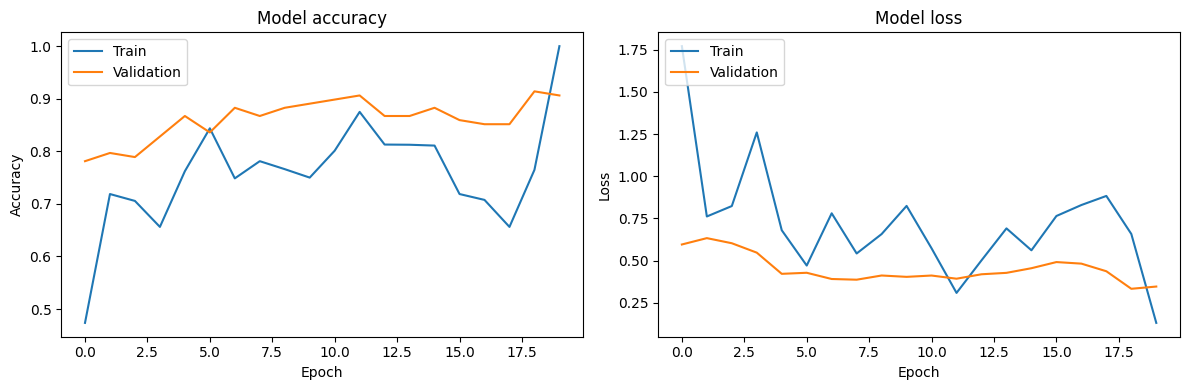

In [21]:


import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

#classification report

#

Found 137 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step

Classification Report:
              precision    recall  f1-score   support

     Barbari       1.00      0.86      0.92         7
        Goat       0.96      1.00      0.98        22
       Harri       0.77      0.83      0.80        12
      Naeimi       0.88      1.00      0.94        51
       Najdi       1.00      1.00      1.00        14
       Roman       1.00      0.60      0.75        15
     Sawakni       0.93      0.81      0.87        16

    accuracy                           0.91       137
   macro avg       0.93      0.87      0.89       137
weighted avg       0.92      0.91      0.91       137



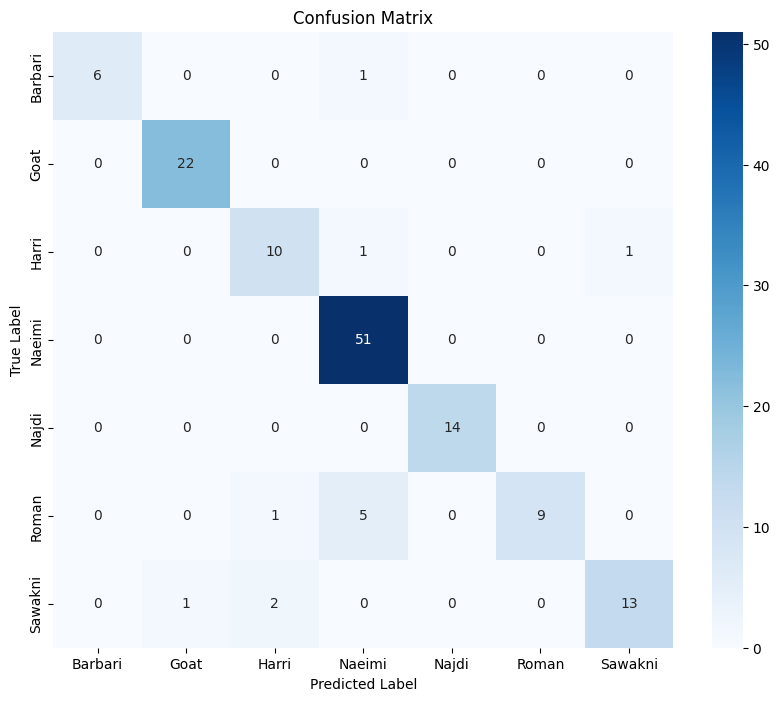

In [22]:


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np


predict_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',
    y_col='label', # Keep y_col to easily get true labels later
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


true_labels_df = pd.get_dummies(val_df['label'])
# Get the class labels (the column names of the one-hot encoded DataFrame)
class_labels = true_labels_df.columns.tolist()
# Convert to numpy array
true_labels = true_labels_df.values

# Method 2: Get true labels and predictions from the generator (more robust)
# Predict method will yield predictions in the same order as the generator
predictions = efficientnet_model.predict(predict_generator, steps=len(predict_generator))


predict_generator.reset()


all_true_labels = []
i = 0

while i < len(predict_generator):
    batch_images, batch_labels = next(predict_generator)
    all_true_labels.extend(batch_labels)
    i += 1

# Convert the list of batches to a numpy array
all_true_labels = np.array(all_true_labels)

# Now, predictions and all_true_labels should be in the same order.

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels from one-hot encoding to class indices
true_classes = np.argmax(all_true_labels, axis=1)

# Get the class names from the generator's class_indices
class_names = list(predict_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)

print("\nClassification Report:")
print(report)

# Optional: Display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:

overall_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")



Overall Accuracy: 0.9124


In [24]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

img_height, img_width = 224, 224

index_to_label = {v: k for k, v in class_indices.items()}


test_filenames = sorted(os.listdir(test_dir))
test_images = []

for fname in test_filenames:
    path = os.path.join(test_dir, fname)
    img = Image.open(path).resize((img_height, img_width)).convert('RGB')
    img_array = img_to_array(img) / 255.0
    test_images.append(img_array)

test_images = np.array(test_images)

pred_probs = efficientnet_model.predict(test_images, verbose=1)
pred_indices = np.argmax(pred_probs, axis=1)
pred_labels = [index_to_label[i] for i in pred_indices]


submission_df = pd.DataFrame({
    'filename': test_filenames,
    'label': pred_labels
})
submission_df.to_csv('submission.csv', index=False)

print("✅ تمت التنبؤات، وتم إنشاء الملف submission.csv بنجاح.")


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
✅ تمت التنبؤات، وتم إنشاء الملف submission.csv بنجاح.



 Predicted label: Barbari


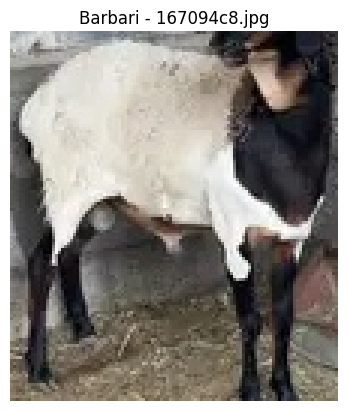

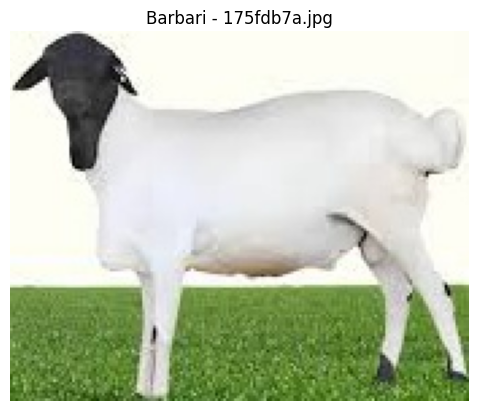


 Predicted label: Roman


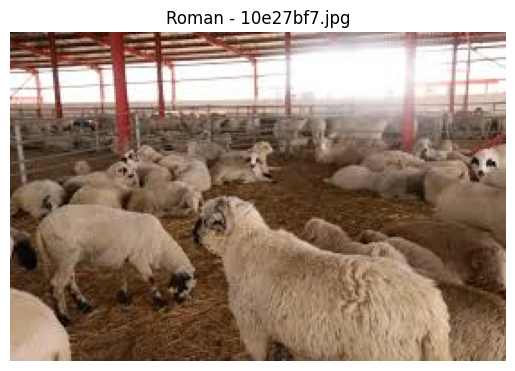


 Predicted label: Sawakni


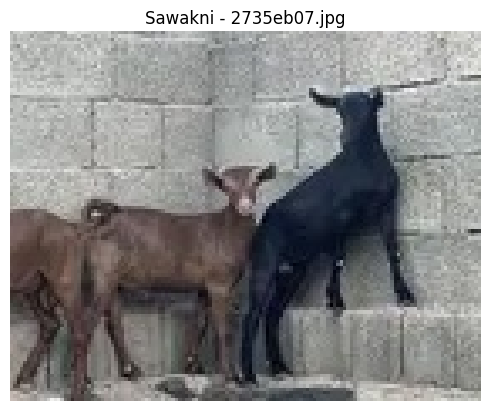


 Predicted label: Goat


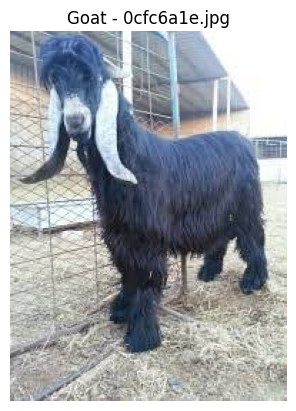


 Predicted label: Naeimi


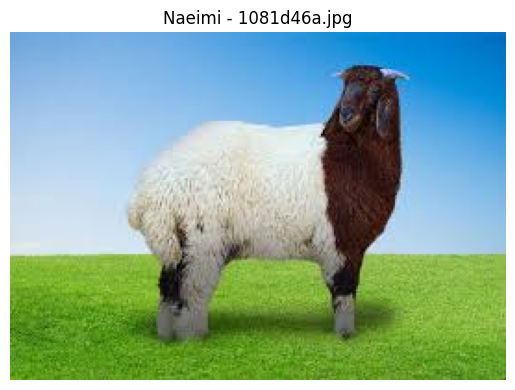

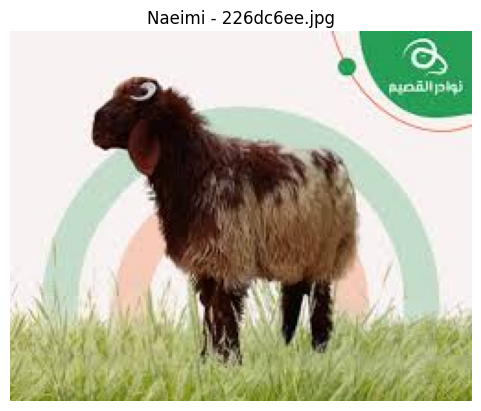

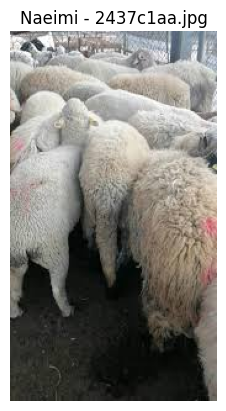


 Predicted label: Harri


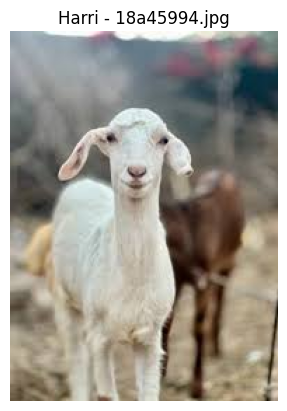

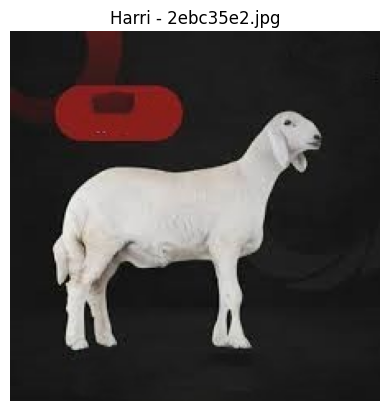


 Predicted label: Najdi


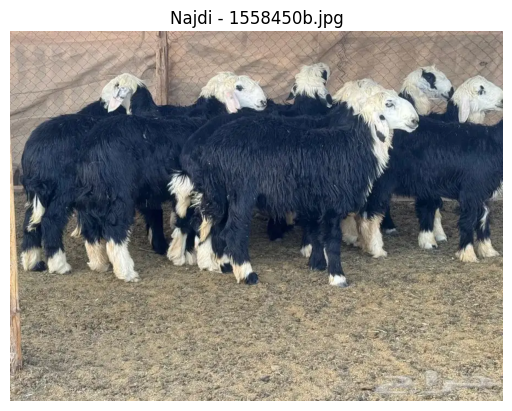

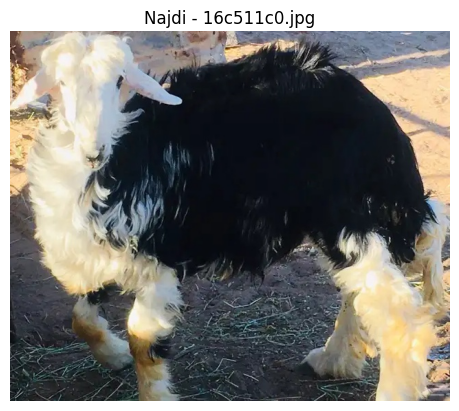

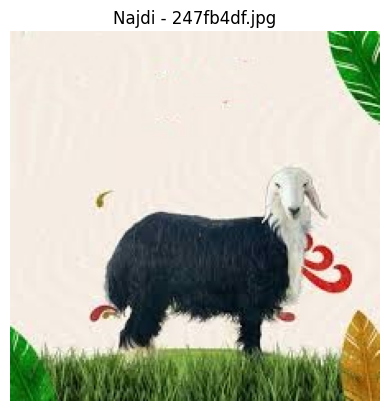

In [25]:
from collections import defaultdict

grouped = defaultdict(list)
for fname, label in zip(test_filenames, pred_labels):
    grouped[label].append(fname)


for label, files in grouped.items():
    print(f"\n Predicted label: {label}")
    for fname in files[:3]:
        path = os.path.join(test_dir, fname)
        img = Image.open(path)
        plt.imshow(img)
        plt.title(f"{label} - {fname}")
        plt.axis('off')
        plt.show()


In [26]:


print(submission_df.head())
submission_df.columns

       filename    label
0  0306fa89.jpg  Barbari
1  0345e3ca.jpg    Roman
2  0551a473.jpg  Sawakni
3  06e1783d.jpg     Goat
4  08b9981b.jpg     Goat


Index(['filename', 'label'], dtype='object')

In [27]:

print(f"\nTotal number of rows in submission.csv: {len(submission_df)}")


Total number of rows in submission.csv: 144
